# Movie Recommendation
### Project 4 PSL542
### Abhishek Jain (661363274), Rahul Sharma (656504734)

- Initialization

In [1]:
import pandas as pd
import warnings, re
#import implicit
import seaborn as sns
sns.set_theme()
from sklearn.preprocessing import minmax_scale
import scipy.sparse as sparse
from sklearn.neighbors import NearestNeighbors

In [2]:
with warnings.catch_warnings(record=True):
    movies = pd.read_table('recommender_app/dataset/movies.dat', sep='::', encoding='iso-8859-1',header=None, names= ['MovieID', 'Title', 'Genres'])
    ratings = pd.read_table('recommender_app/dataset/ratings.dat', sep='::', encoding='iso-8859-1',header=None, names= ["UserID","MovieID","Rating","Timestamp"])
    users = pd.read_table('recommender_app/dataset/users.dat', sep='::', encoding='iso-8859-1',header=None, names=["UserID","Gender","Age","Occupation","Zip"])

In [3]:
len(movies)

3883

- Data Preparation

In [36]:
def title_production_yr_split(title):
    groups=re.search('^(.+)\((\d+)\)$',title)
    movie_title=groups.group(1).strip()
    production_year=int(groups.group(2))
    return {"Title_1":movie_title, "Production_Year":production_year}
applied_df = movies.apply(lambda row: title_production_yr_split(row.Title), axis='columns', result_type='expand')
movies = pd.concat([movies, applied_df], axis='columns')
movies["Decade"] =movies.Production_Year//10*10
movies.head(2)

,MovieID,Title,Genres,Title_1,Production_Year,Decade
0,1,Toy Story (1995),Animation|Children's|Comedy,Toy Story,1995,1990
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Jumanji,1995,1990


In [37]:
dummies_genres = movies['Genres'].str.get_dummies()
movies_cleaned = pd.concat([movies,dummies_genres],axis=1)
movies_cleaned.drop('Genres',inplace=True,axis=1)
total_genres=dummies_genres.columns.values
movies_cleaned.head(2)

,MovieID,Title,Title_1,Production_Year,Decade,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Toy Story,1995,1990,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Jumanji,1995,1990,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [38]:
ratings.head(2)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109


In [39]:
users.head()

,UserID,Gender,Age,Occupation,Zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


### Summary

In [40]:
print('Unique users:', ratings.UserID.nunique())
print('Unique movies:', ratings.MovieID.nunique())
print('Unique ratings:', ratings.Rating.unique())
print('Average rating:', round(ratings.Rating.mean(), 2))

Unique users: 6040
Unique movies: 3706
Unique ratings: [5 3 4 2 1]
Average rating: 3.58


<AxesSubplot: ylabel='Frequency'>

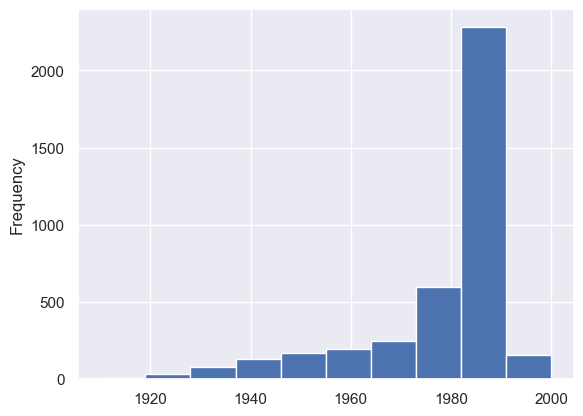

In [41]:
# Movies production count by Decades
movies_cleaned["Decade"].plot(kind="hist",bins=10)

#### Genre movies count

In [42]:
genre_total=movies_cleaned.drop(["MovieID","Title","Title_1","Production_Year",'Decade'],axis=1).sum().sort_values()

<AxesSubplot: title={'center': 'Genres Counts'}>

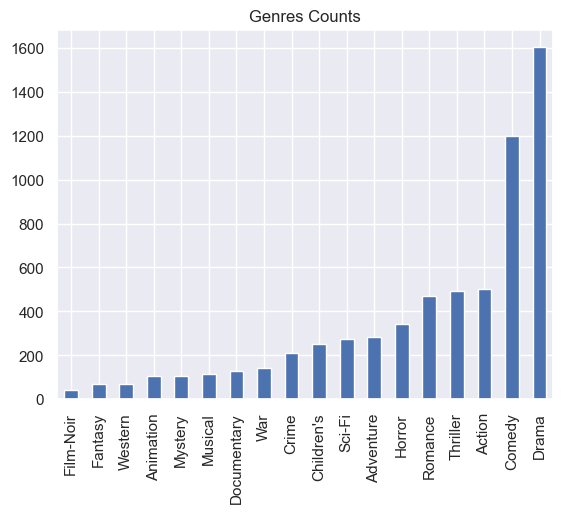

In [43]:
genre_total.plot(kind='bar',title='Genres Counts')

In [47]:
mov_rat = movies_cleaned.merge(ratings, on='MovieID')
mov_rat.head(2)

,MovieID,Title,Title_1,Production_Year,Decade,Action,Adventure,Animation,Children's,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,UserID,Rating,Timestamp
0,1,Toy Story (1995),Toy Story,1995,1990,0,0,1,1,1,...,0,0,0,0,0,0,0,1,5,978824268
1,1,Toy Story (1995),Toy Story,1995,1990,0,0,1,1,1,...,0,0,0,0,0,0,0,6,4,978237008


<AxesSubplot: >

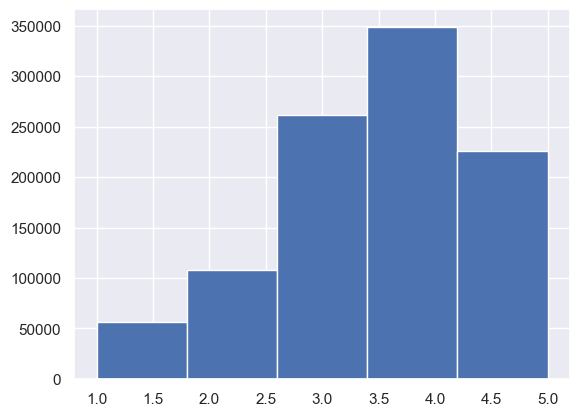

In [48]:
mov_rat['Rating'].hist(bins=5)

Next, let's use join plot to check correlation between the average rating and the number of ratings.
You will notice the upward trend from the scatterplot showing that the pipular movies get the higher ratings.
We will use this strategy for recommender system Method 2.

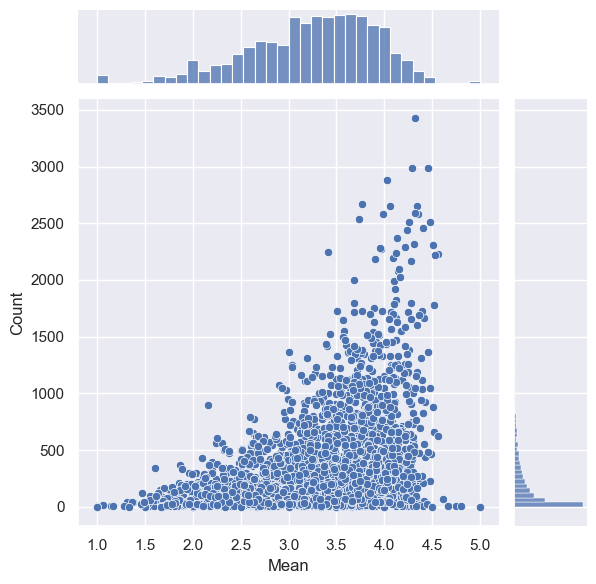

In [49]:
genre_agg= mov_rat[['MovieID','Title_1','Rating']].groupby(['MovieID','Title_1'])['Rating'].agg(Mean='mean', Count='count')
sns.jointplot(data=genre_agg,x="Mean",y="Count")

## Recommender System 1: Method 1-

In [50]:
def recommender1_m1(genre,n=5):
    mov_rat_adv = mov_rat[(mov_rat[genre]==1)]
    mov_rat_adv.reset_index(drop=True,inplace=True)
    genre_grouped= mov_rat_adv[['MovieID','Title_1','Rating']].groupby(['MovieID','Title_1','Rating']).size()
    genre_grouped_df = genre_grouped.to_frame('count').reset_index()
    genre_rating = genre_grouped_df.pivot(index=['MovieID','Title_1'],columns='Rating',values='count').fillna(0)
    genre_rating.columns=['r1','r2','r3','r4','r5']
    def moviescore(r):
        return r.r1*(-1)+r.r2*(-0.5)+r.r3*(-0.1)+r.r4*(0.5)+r.r5
    genre_rating['score']=genre_rating.apply(moviescore,axis=1)
    return genre_rating.score.nlargest(n=n)

### Top 5 Movies in dataset

In [51]:
GENRE_FOR_RECOMMENDATION=total_genres[2]
print(f"Recommendation for : {GENRE_FOR_RECOMMENDATION}")
recommender1_m1(genre=GENRE_FOR_RECOMMENDATION,n=5)

Recommendation for : Animation


MovieID  Title_1                 
1        Toy Story                   1156.5
3114     Toy Story 2                  944.6
2355     Bug's Life, A                686.8
1148     Wrong Trousers, The          660.2
2987     Who Framed Roger Rabbit?     562.1
Name: score, dtype: float64

## Recommender System 1: Method 2-

In [54]:
def recommender1_m2(genre,n=5,min_count=100):
    mov_rat_adv = mov_rat[(mov_rat[genre]==1)]
    mov_rat_adv.reset_index(drop=True,inplace=True)
    genre_agg= mov_rat_adv[['MovieID','Title_1','Rating']].groupby(['MovieID','Title_1'])['Rating'].agg(Mean='mean', Count='count')
    genre_agg_filtered = genre_agg[genre_agg['Count']>min_count].reset_index()
    genre_agg_filtered.sort_values(by="Mean", ascending=False,inplace=True)
    return genre_agg_filtered.head(n)

In [55]:
GENRE_FOR_RECOMMENDATION=total_genres[2]
print(f"Recommendation for : {GENRE_FOR_RECOMMENDATION}")
recommender1_m2(genre=GENRE_FOR_RECOMMENDATION,min_count=100,n=5)

Recommendation for : Animation


,MovieID,Title_1,Mean,Count
16,745,"Close Shave, A",4.520548,657
27,1148,"Wrong Trousers, The",4.507937,882
14,720,Wallace & Gromit: The Best of Aardman Animation,4.426941,438
29,1223,"Grand Day Out, A",4.361522,473
75,3429,Creature Comforts,4.335766,274


## Recommender System 2
### Using implict library

In [62]:
with warnings.catch_warnings(record=True):
    dataset= mov_rat[["MovieID","UserID","Rating"]]
    dataset['MovieID']=dataset['MovieID'].astype("category")
    dataset['UserID']=dataset['UserID'].astype("category")
    dataset['MovieID'] = dataset['MovieID'].cat.codes
    dataset['UserID'] = dataset['UserID'].cat.codes

sparse_item_user = sparse.csr_matrix((dataset['Rating'].astype(int), (dataset['MovieID'], dataset['UserID'])))
sparse_user_item = sparse.csr_matrix((dataset['Rating'].astype(int), (dataset['UserID'], dataset['MovieID'])))

In [63]:
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)
alpha_val = 15
data_conf = (sparse_user_item * alpha_val).astype('int')
model.fit(data_conf)

  0%|          | 0/20 [00:00<?, ?it/s]

In [64]:
n_similar = 10

### User Based Collaborative Filtering (UBCF) Method 1:

In [65]:
#------------------------------
# CREATE USER RECOMMENDATIONS
#------------------------------

# Create recommendations for user with id 2025
user_id = 501

# Use the implicit recommender.
similar = model.recommend(user_id,user_items=sparse_user_item[user_id],N=n_similar)
recommendations = pd.DataFrame({'movies': similar[0], 'score': similar[1]})
recommendations

,movies,score
0,2651,1.002129
1,346,0.979630
2,1120,0.976349
3,802,0.969866
4,1108,0.950449
5,1106,0.949688
6,253,0.948142
7,1167,0.943763
8,2203,0.943099
9,1173,0.936746


### Item Based Collaborative Filtering (UBCF) Method 2:

In [67]:
#---------------------
# FIND SIMILAR ITEMS
#---------------------

# Find the 10 most similar
item_id = 100
# Use implicit to get similar items.
similar = model.similar_items(item_id, n_similar)
recommendations = pd.DataFrame({'movies': similar[0], 'score': similar[1]})
recommendations

,movies,score
0,100,1.000000
1,1323,0.896686
2,449,0.879160
3,408,0.853982
4,127,0.825650
5,384,0.825453
6,2573,0.805680
7,1030,0.802474
8,3474,0.798360
9,2389,0.786497


## Custom Implementations:
## Recommender 2 Method 1: User Based Collaborative Filtering (UBCF)

In [68]:
# Prepare dataset and train model
dataset = mov_rat.pivot_table(index="UserID",columns='MovieID',values="Rating")
dataset_norm=dataset.fillna(0).subtract(dataset.mean(axis=1),axis='rows')
sparse_usr_movie = sparse.csr_matrix(dataset_norm.values)
ubcf_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
ubcf_knn_fit=ubcf_knn.fit(sparse_usr_movie)

In [69]:
def recommender2_ubcf(user,ubcf_knn_fit,n_recommendations=20):
    distances, indices=ubcf_knn_fit.kneighbors(user, n_neighbors=n_recommendations+1)
    indices=indices.squeeze().tolist()[1:]
    distances=distances.squeeze().tolist()[1:]
    uid_movies = dataset.filter(items=indices,axis=0).fillna(0)
    weighted_score = uid_movies.multiply(distances, axis=0).mean(axis=0)
    recommendations = pd.Series(data=minmax_scale(weighted_score, feature_range=(0,5)),index=uid_movies.columns)
    recommendations.index.name = "MovieID"
    return recommendations.sort_values(ascending=False).astype(int)


In [71]:
# Recommendation for 501 user
user=sparse_usr_movie[501,:]
n_recommendations=20
mypred=recommender2_ubcf(user,ubcf_knn_fit,n_recommendations)
mypred.head(100)

MovieID
260     5
1210    4
2396    4
1196    4
593     4
       ..
969     2
3685    2
2490    2
2001    2
2683    2
Length: 100, dtype: int64

In [72]:
# Exclude existing scores
#dataset.filter(items=[501]).notnull()

## Recommender system 2- M2- Item Based Collaborative Filtering (IBCF)

In [73]:
# Prepare dataset and train model
from sklearn.neighbors import NearestNeighbors
dataset = mov_rat.pivot_table(index="MovieID",columns='UserID',values="Rating")
dataset_norm=dataset.fillna(0)
sparse_movie_usr = sparse.csr_matrix(dataset_norm.values)
model2_ibcf = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
ibcf_knn_fit=model2_ibcf.fit(sparse_movie_usr)

In [74]:
def recommender2_ibcf(movie,ibcf_knn_fit,n_recommendations=20):
    distances, indices=ibcf_knn_fit.kneighbors(movie, n_neighbors=n_recommendations+1)
    indices=indices.squeeze().tolist()[1:]
    distances=distances.squeeze().tolist()[1:]
    recommendations = pd.DataFrame({"Movies":indices,"Score":distances})
    return recommendations.sort_values(by="Score",ascending=False)

In [75]:
# Recommend movies based on Item 101
#movie=sparse_movie_usr[101,:]
movie=dataset_norm.filter(items=[101],axis=0)
n_recommendations=20
recommender2_ibcf(movie,ibcf_knn_fit,n_recommendations)

,Movies,Score
19,2744,0.720790
18,2347,0.717095
17,1732,0.716713
16,1295,0.715951
15,216,0.714696
14,1384,0.714019
13,1743,0.709423
12,457,0.707205
11,313,0.705452
10,548,0.705311
